# 1. Install Requirements

In [ ]:
!pip install -U sentence-transformers

# 2. Load LaBSE

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = model.encode(sentences)
print(embeddings)

[[ 0.02882476 -0.0060238  -0.05947006 ... -0.03002251 -0.02960703
   0.00067478]
 [-0.05550232  0.02546488 -0.02157256 ...  0.02932104  0.01150039
  -0.00848788]]


# 3. Load & Preprocess Data

To run cell below you should put all data files on the same folder as this notebook.

In [ ]:
import pandas as pd
import json

with open("train.model-agnostic.json", "r") as f:
    train_agnostic = pd.DataFrame(json.loads(f.read()))
with open("train.model-aware.json", "r") as f:
    train_aware = pd.DataFrame(json.loads(f.read()))
with open("val.model-agnostic.json", "r") as f:
    val_agnostic = pd.DataFrame(json.loads(f.read()))
with open("val.model-aware.v2.json", "r") as f:
    val_aware = pd.DataFrame(json.loads(f.read()))
with open("trial-v1.json", "r") as f:
    test = pd.DataFrame(json.loads(f.read()))

> "The ref key therefore indicate whether target, source or both of these fields contain the semantic information necessary to establish whether a datapoint is a hallucination."

In [ ]:
tasks = ['MT', 'DM', 'PG']

def preprocess_data(data_df):
    output = {"hyp": {'all': [], 'MT': [], 'DM': [], 'PG': []},
              "tgt": {'all': [], 'MT': [], 'DM': [], 'PG': []},
              "labels": {'all': [], 'MT': [], 'DM': [], 'PG': []}}
    for index, row in data_df.iterrows():
        hyp = row['hyp']
        if row['ref'] == 'either' or row['ref'] == 'tgt':
            tgt = row['tgt']
        else:
            tgt = row['src']

        task = row['task'].strip()
        if task in tasks:
            output['hyp'][task].append(hyp)
            output['tgt'][task].append(tgt)
            output['labels'][task].append(row['p(Hallucination)'])

            output['hyp']['all'].append(hyp)
            output['tgt']['all'].append(tgt)
            output['labels']['all'].append(row['p(Hallucination)'])

    return output

In [ ]:
p_val_agnostic = preprocess_data(val_agnostic)
p_val_aware = preprocess_data(val_aware)
p_test = preprocess_data(test)

# 4. Get Embeddings & Calculate Similarity Scores

In [ ]:
import numpy as np

def encode_LaBSE(p_data, model):
    output = {"hyp": {},
              "tgt": {},
              "labels": {}}
    for key, value in p_data['hyp'].items():
        output['hyp'][key] = model.encode(value)
    for key, value in p_data['tgt'].items():
        output['tgt'][key] = model.encode(value)
    for key, value in p_data['labels'].items():
        output['labels'][key] = np.array(value)

    return output

In [ ]:
e_val_agnostic = encode_LaBSE(p_val_agnostic, model)
e_val_aware = encode_LaBSE(p_val_aware, model)
e_test = encode_LaBSE(p_test, model)

In [ ]:
e_test['hyp']['all'].shape

(80, 768)

In [ ]:
def similarity(embeddings_1, embeddings_2):
    return np.sum(np.multiply(embeddings_1, embeddings_2), 1)

def calculate_similarity(e_data):
    output = {
        'scores': {},
        'labels': {},
    }
    output['labels'] = e_data['labels']
    for key in e_data['hyp'].keys():
        output['scores'][key] = 1 - similarity(e_data['hyp'][key], e_data['tgt'][key])

    return output

In [ ]:
sl_val_agnostic = calculate_similarity(e_val_agnostic)
sl_val_aware = calculate_similarity(e_val_aware)
sl_test = calculate_similarity(e_test)

# 5. Evaluation

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats


def AUC_metric(scores, labels, plot=True):
    y = np.where(labels >= 0.5, 1, 0)
    pred = scores
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')

    if plot:
        display.plot()
        plt.show()
    return roc_auc

def accuracy(scores, labels, threshold=0.5):
    y = np.where(labels >= 0.5, 1, 0)
    pred = np.where(scores >= threshold, 1, 0)

    return metrics.accuracy_score(y, pred)

def S_correlation(scores, labels):
    spearman_corr, p_value = scipy.stats.spearmanr(scores, labels)
    return spearman_corr

def evaluate(name, scores, labels, plot=True):
    print(name, "accuracy:", accuracy(scores, labels))
    print(name, "spearman correlation:", S_correlation(scores, labels))
    auc = AUC_metric(scores, labels, plot=plot)
    print(name, "auc:", auc)

In [ ]:
def evaluate_data(data):
    for task in tasks:
        print("task:", task)
        evaluate(f'Val Agnostic, task: {task}', data['scores'][task], data['labels'][task], False)

    print("All Data:")
    evaluate(f'Val Agnostic', data['scores']['all'], data['labels']['all'], True)

task: MT
Val Agnostic, task: MT accuracy: 0.6203208556149733
Val Agnostic, task: MT spearman correlation: 0.6128806933211439
Val Agnostic, task: MT auc: 0.873282087118565
task: DM
Val Agnostic, task: DM accuracy: 0.6577540106951871
Val Agnostic, task: DM spearman correlation: 0.3969303285662607
Val Agnostic, task: DM auc: 0.7024027459954233
task: PG
Val Agnostic, task: PG accuracy: 0.712
Val Agnostic, task: PG spearman correlation: 0.461378808445309
Val Agnostic, task: PG auc: 0.6777777777777778
All Data:
Val Agnostic accuracy: 0.657314629258517
Val Agnostic spearman correlation: 0.47621837330082306


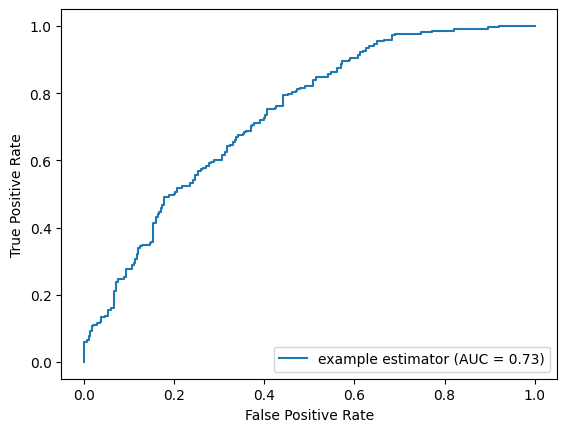

Val Agnostic auc: 0.7341081981128996


In [ ]:
evaluate_data(sl_val_agnostic)

task: MT
Val Agnostic, task: MT accuracy: 0.5904255319148937
Val Agnostic, task: MT spearman correlation: 0.6229453159381316
Val Agnostic, task: MT auc: 0.824515690495072
task: DM
Val Agnostic, task: DM accuracy: 0.6542553191489362
Val Agnostic, task: DM spearman correlation: 0.48677210587589964
Val Agnostic, task: DM auc: 0.7272727272727272
task: PG
Val Agnostic, task: PG accuracy: 0.792
Val Agnostic, task: PG spearman correlation: 0.2126266919367341
Val Agnostic, task: PG auc: 0.6243201243201242
All Data:
Val Agnostic accuracy: 0.6646706586826348
Val Agnostic spearman correlation: 0.39459111221328613


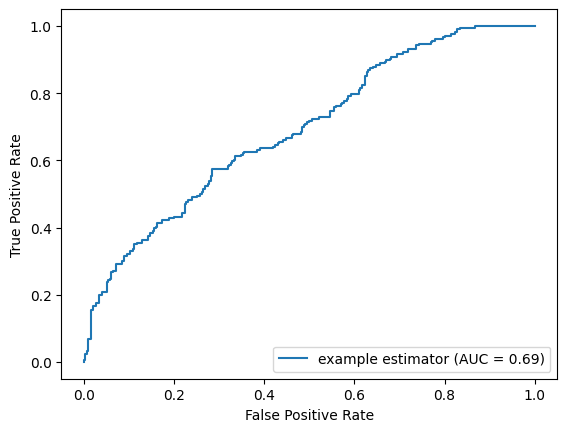

Val Agnostic auc: 0.6918874444627283


In [ ]:
evaluate_data(sl_val_aware)

task: MT
Val Agnostic, task: MT accuracy: 0.5714285714285714
Val Agnostic, task: MT spearman correlation: 0.8493611136130801
Val Agnostic, task: MT auc: 0.957516339869281
task: DM
Val Agnostic, task: DM accuracy: 0.6111111111111112
Val Agnostic, task: DM spearman correlation: 0.3254103627170718
Val Agnostic, task: DM auc: 0.71875
task: PG
Val Agnostic, task: PG accuracy: 0.7777777777777778
Val Agnostic, task: PG spearman correlation: 0.7299432232335216
Val Agnostic, task: PG auc: 1.0
All Data:
Val Agnostic accuracy: 0.6125
Val Agnostic spearman correlation: 0.469378050127969


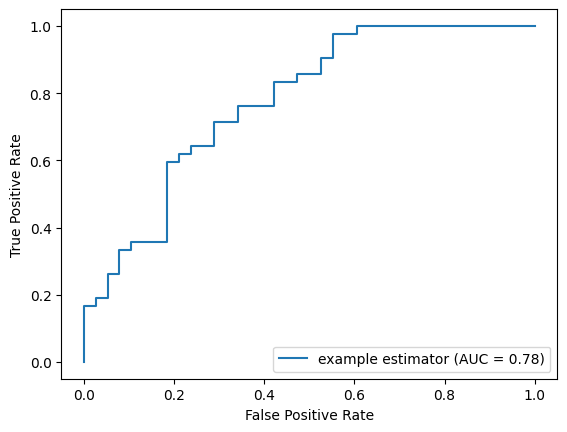

Val Agnostic auc: 0.7756892230576441


In [ ]:
evaluate_data(sl_test)

In [ ]:
# All test and val data together
all_scores = {}
all_labels = {}
all_sl = {}
for task in tasks + ['all']:
    all_scores[task] = np.concatenate([sl_val_agnostic['scores'][task], sl_val_aware['scores'][task], sl_test['scores'][task]])
    all_labels[task] = np.concatenate([sl_val_agnostic['labels'][task], sl_val_aware['labels'][task], sl_test['labels'][task]])

all_sl['scores'] = all_scores
all_sl['labels'] = all_labels

task: MT
Val Agnostic, task: MT accuracy: 0.6024390243902439
Val Agnostic, task: MT spearman correlation: 0.6411878748370609
Val Agnostic, task: MT auc: 0.8553472671119728
task: DM
Val Agnostic, task: DM accuracy: 0.6520681265206812
Val Agnostic, task: DM spearman correlation: 0.43252499050327864
Val Agnostic, task: DM auc: 0.7165363657900972
task: PG
Val Agnostic, task: PG accuracy: 0.752895752895753
Val Agnostic, task: PG spearman correlation: 0.3782288954247939
Val Agnostic, task: PG auc: 0.6740724762726488
All Data:
Val Agnostic accuracy: 0.6574074074074074
Val Agnostic spearman correlation: 0.44582436756657134


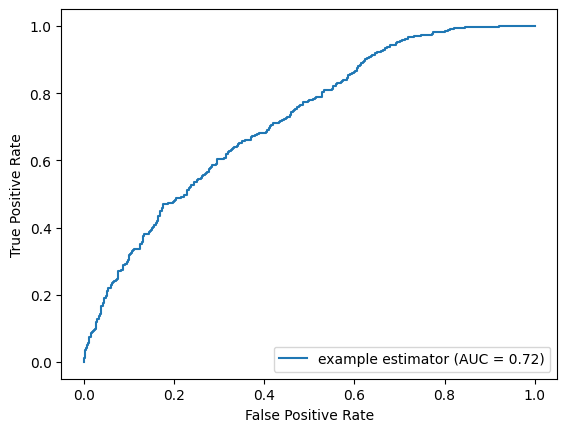

Val Agnostic auc: 0.7195761278326879


In [ ]:
evaluate_data(all_sl)

# 6. Results

Data         | AUC | Accuracy | Spearman Correlation |
----------   | --- | -------- | ---------------------|
Val Agnostic |0.73 | 0.65     | 0.47                 |
Val Aware    |0.69 | 0.66     | 0.39                 |
Test         |0.78 | 0.61     | 0.46                 |
All          |0.72 | 0.65     | 0.44                 |

<table>
    <tr>
        <th colspan="1">
            Data
        </th>
        <th colspan="4">
            AUC
        </th>
        <th colspan="4">
            Accuracy
        </th>
        <th colspan="4">
            Spearman Correlation
        </th>
    </tr>
    <tr>
        <th>
            ...
        </th>
        <th>
            MT
        </th>
        <th>
            DM
        </th>
        <th>
            PG
        </th>
        <th>
            All
        </th>
        <th>
            MT
        </th>
        <th>
            DM
        </th>
        <th>
            PG
        </th>
        <th>
            All
        </th>
        <th>
            MT
        </th>
        <th>
            DM
        </th>
        <th>
            PG
        </th>
        <th>
            All
        </th>
    </tr>
    <tr>
        <td>
            Val Agnostic
        </td>
        <td>
            0.87
        </td>
        <td>
            0.70
        </td>
        <td>
            0.67
        </td>
        <td>
            0.73
        </td>
        <td>
            62
        </td>
        <td>
            65
        </td>
        <td>
            71
        </td>
        <td>
            65
        </td>
        <td>
            0.61
        </td>
        <td>
            0.39
        </td>
        <td>
            0.46
        </td>
        <td>
            0.47
        </td>
    </tr>
    <tr>
        <td>
            Val Aware
        </td>
        <td>
            0.82
        </td>
        <td>
            0.72
        </td>
        <td>
            0.62
        </td>
        <td>
            0.69
        </td>
        <td>
            59
        </td>
        <td>
            65
        </td>
        <td>
            79
        </td>
        <td>
            66
        </td>
        <td>
            0.62
        </td>
        <td>
            0.48
        </td>
        <td>
            0.21
        </td>
        <td>
            0.39
        </td>
    </tr>
    <tr>
        <td>
            Test
        </td>
        <td>
            0.95
        </td>
        <td>
            0.71
        </td>
        <td>
            1
        </td>
        <td>
            0.78
        </td>
        <td>
            57
        </td>
        <td>
            61
        </td>
        <td>
            77
        </td>
        <td>
            61
        </td>
        <td>
            0.95
        </td>
        <td>
            0.32
        </td>
        <td>
            0.72
        </td>
        <td>
            0.46
        </td>
    </tr>
    <tr>
        <td>
            All Data
        </td>
        <td>
            0.85
        </td>
        <td>
            0.71
        </td>
        <td>
            0.67
        </td>
        <td>
            0.72
        </td>
        <td>
            60
        </td>
        <td>
            65
        </td>
        <td>
            75
        </td>
        <td>
            65
        </td>
        <td>
            0.64
        </td>
        <td>
            0.43
        </td>
        <td>
            0.37
        </td>
        <td>
            0.44
        </td>
    </tr>
</table>

# 7. Test On Samples

In [ ]:
def show_sample(data, task='all'):
    if task != 'all':
        sample = data[data['task'] == task].sample().iloc[0]
    else:
        sample = data.sample().iloc[0]

    hyp = sample['hyp']
    if sample['ref'] == 'either' or sample['ref'] == 'tgt':
        tgt = sample['tgt']
    else:
        tgt = sample['src']

    hyp, tgt = model.encode([hyp]), model.encode([tgt])
    score = 1 - similarity(hyp, tgt)

    print("Task:", task)
    print("Src:", sample['src'])
    print("Hyp:", sample['hyp'])
    print("Target:", sample['tgt'])
    print("p(Hullucinate):", sample['p(Hallucination)'])
    print("LaBSE p(Hullucinate):", score)
    print("")


In [ ]:
print("Val Agnostic\n")
for task in tasks + ['all']:
    show_sample(val_agnostic, task=task)

Val Agnostic

Task: MT
Src: Ты слышал, как птицы щебечут?
Hyp: Did you hear how the birds smell?
Target: Did you hear the birds tweeting?
p(Hullucinate): 1.0
LaBSE p(Hullucinate): [0.12377262]

Task: DM
Src: They enjoyed a wet summer and a <define> bountiful </define> harvest .
Hyp: (figuratively) Full of food; bountiful.
Target: Having a quantity or amount that is generous or plentiful; ample.
p(Hullucinate): 0.6
LaBSE p(Hullucinate): [0.5462285]

Task: PG
Src: Leave your message after the beep.
Hyp: You'll leave your message after the beep, and you'll be on your way.
Target: Please leave a message at the sound of the tone.
p(Hullucinate): 0.6
LaBSE p(Hullucinate): [0.4901048]

Task: all
Src: Я его узнала.
Hyp: I knew him.
Target: I recognized him.
p(Hullucinate): 0.4
LaBSE p(Hullucinate): [0.10059351]



In [ ]:
print("Val Aware\n")
for task in tasks + ['all']:
    show_sample(val_aware, task=task)

Val Aware

Task: MT
Src: Agbanyeghị etu ha siri dị nwayọọ, bison, elk, muuz, bea, na anụmanụ ukwu niile nwere ike iluso ọgụ.
Hyp: Despite their mild nature, bison, elk, muzzles, bears, and other large animals can all attack.
Target: No matter how docile they may look, bison, elk, moose, bears, and nearly all large animals can attack.
p(Hullucinate): 0.2
LaBSE p(Hullucinate): [0.13755208]

Task: DM
Src: Akira Toriyama uses a timeskip to rejoin us with Gokū and friends in Dragon Ball Chapter 113 , three years after Gokū leaves Uranai Baba 's Palace for his global trek .
Hyp: A short , fast jump , especially one that takes place in a particular time 
Target: An instance of fast-forwarding a substantial amount of time , such as years or decades , as a narrative device in a story , quickly aging characters and developing events .
p(Hullucinate): 0.6
LaBSE p(Hullucinate): [0.65280795]

Task: PG
Src: Lastly, it should be stated that food labelling can never be a manual for good diet.
Hyp: Foo

In [ ]:
print("Test\n")
for task in tasks + ['all']:
    show_sample(test, task=task)

Test

Task: MT
Src: Le groupe séparatiste de Ferhat Mehenni a conclu un compromis avec le groupe islamiste radical Rachad pour la déstabilisation de l'Algérie. C'est ce qui a conduit l'Algérie à officiellement considérer les deux groupes comme des organisations terroristes.
Hyp: Farhat Mehenni's separatist group concluded a compromise with the radical Islamist group Rachad for the destabilization of Algeria. This led Algeria to officially consider the two groups as terrorist organizations.
Target: Ferhat Mehenni's separatist group cut a deal with the radical Islamist group Rachad to destabilize Algeria. That's what led Algeria to officially consider both groups as terrorist organizations.
p(Hullucinate): 0.0
LaBSE p(Hullucinate): [0.02732861]

Task: DM
Src: And thou , our Mother , twice two centuries <define> young </define> ,
Hyp: (obsolete) Old; old-fashioned.
Target: (Not) advanced in age; (far towards or) at a specified stage of existence or age.
p(Hullucinate): 1.0
LaBSE p(Hulluci